In [142]:
import numpy as np
from scipy.integrate import odeint,solve_ivp
import scipy
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
from autograd import jacobian
from mpl_toolkits import mplot3d
import time
from quadprog import solve_qp
from numba import njit, cfunc, jit
import numba
import autograd.numpy as gnp
import casadi as cd

In [143]:
@jit(nopython=True)
def DynamicJIT_(t,X,U):
    x,y,z,psi,the,phi,xd,yd,zd,p,q,r = X
    u1,u2,u3,u4 = U   
    S = np.sin
    C = np.cos  
    T = np.tan  
    m = 0.468;
    #m = 1
    l = 0.225;
    b = 2.98e-6;
    d = 1.14e-7
    Iy = 4.856e-3;
    Ix = 4.856e-3;
    Iz = 8.801e-3
    g = 9.81; 
    #g = 11.0
    ft = b*(u1**2+u2**2+u3**2+u4**2)
    tx = b*l*(u3**2-u1**2)
    ty = b*l*(u4**2-u2**2)
    tz = -d*(-u1**2+u2**2-u3**2+u4**2)
    dxdt = [xd, \
            yd, \
            zd, \
            q*S(phi)/C(the)+r*C(phi)/C(the), \
            q*C(phi)-r*S(phi), \
            p+q*(S(phi)*T(the))+r*(C(phi)*T(the)), \
            -(S(phi)*S(psi)+C(phi)*C(psi)*S(the))/m*ft, \
            -(S(phi)*C(psi)+C(phi)*S(psi)*S(the))/m*ft, \
            -g + C(phi)*C(the)/m*ft, \
            (Iy-Iz)/Ix*q*r + 1/Ix*tx, \
            (Iz-Ix)/Iy*p*r + 1/Iy*ty, \
            (Ix-Iy)/Iz*p*q + 1/Iz*tz]
    return np.array(dxdt)

def DynamicCasadi_(t,X,U):
    x,y,z,psi,the,phi,xd,yd,zd,p,q,r = X
    u1,u2,u3,u4 = U   
    S = cd.sin
    C = cd.cos  
    T = cd.tan  
    m = 0.468;
    #m = 1
    l = 0.225;
    b = 2.98e-6;
    d = 1.14e-7
    Iy = 4.856e-3;
    Ix = 4.856e-3;
    Iz = 8.801e-3
    g = 9.81; 
    #g = 11.0
    ft = b*(u1**2+u2**2+u3**2+u4**2)
    tx = b*l*(u3**2-u1**2)
    ty = b*l*(u4**2-u2**2)
    tz = -d*(-u1**2+u2**2-u3**2+u4**2)
    dxdt = [xd, \
            yd, \
            zd, \
            q*S(phi)/C(the)+r*C(phi)/C(the), \
            q*C(phi)-r*S(phi), \
            p+q*(S(phi)*T(the))+r*(C(phi)*T(the)), \
            -(S(phi)*S(psi)+C(phi)*C(psi)*S(the))/m*ft, \
            -(S(phi)*C(psi)+C(phi)*S(psi)*S(the))/m*ft, \
            -g + C(phi)*C(the)/m*ft, \
            (Iy-Iz)/Ix*q*r + 1/Ix*tx, \
            (Iz-Ix)/Iy*p*r + 1/Iy*ty, \
            (Ix-Iy)/Iz*p*q + 1/Iz*tz]
    return cd.vertcat(*dxdt)

def RK4(dt,X,U):
    k1 = DynamicCasadi_(0,X,U)
    k2 = DynamicCasadi_(0,X+dt/2*k1,U)
    k3 = DynamicCasadi_(0,X+dt/2*k2,U)
    k4 = DynamicCasadi_(0,X+dt*k3,U)
    


@njit
def Dynamic5JIT(lx,u,dt):
    DIFF = 200
    ddt = dt/DIFF
    currentx = lx
    for i in range(DIFF):
        currentx = currentx + DynamicJIT_(0,currentx,u)*ddt
    return currentx

@njit
def getTrajectoryUJIT(x0,U,dt):
    STEPS = len(U)+1
    x_dim = len(x0)
    TrueX = np.zeros((x_dim,STEPS))
    TrueX[:,0] = x0
    STEPS = len(U)+1
    for i in range(STEPS-1):
        #TrueX[:,i+1] = Dynamic4JIT(TrueX[:,i],U[i],dt)
        TrueX[:,i+1] = Dynamic5JIT(TrueX[:,i],U[i],dt)
        #TrueX[:,i+1] = Dynamic(TrueX[:,i],U[i],dt)
    return TrueX.T


import sympy

def getABexpress():
    X = sympy.symbols('x1:13')
    U = sympy.symbols('u1:5')
    x,y,z,psi,the,phi,xd,yd,zd,p,q,r = X
    u1,u2,u3,u4 = U
    m,l,b,d,Iy,Ix,Iz,g = sympy.symbols('m,l,b,d,Iy,Ix,Iz,g')

    S = sympy.sin
    C = sympy.cos  
    T = sympy.tan
    """m = 0.468;
    l = 0.225;
    b = 2.98e-6;
    d = 1.14e-7
    Iy = 4.856e-3;
    Ix = 4.856e-3;
    Iz = 8.801e-3
    g = 9.81;"""

    ft = b*(u1**2+u2**2+u3**2+u4**2)
    tx = b*l*(u3**2-u1**2)
    ty = b*l*(u4**2-u2**2)
    tz = -d*(-u1**2+u2**2-u3**2+u4**2)

    dxdt = [xd, \
            yd, \
            zd, \
            q*S(phi)/C(the)+r*C(phi)/C(the), \
            q*C(phi)-r*S(phi), \
            p+q*(S(phi)*T(the))+r*(C(phi)*T(the)), \
            -(S(phi)*S(psi)+C(phi)*C(psi)*S(the))/m*ft, \
            -(S(phi)*C(psi)+C(phi)*S(psi)*S(the))/m*ft, \
            -g + C(phi)*C(the)/m*ft, \
            (Iy-Iz)/Ix*q*r + 1/Ix*tx, \
            (Iz-Ix)/Iy*p*r + 1/Iy*ty, \
            (Ix-Iy)/Iz*p*q + 1/Iz*tz]

    A = sympy.Matrix(dxdt).jacobian(X)
    B = sympy.Matrix(dxdt).jacobian(U)
    print(A)
    print(B)
#getABexpress()

@jit
def getABJIT(x,u,dt):
    
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12 = x
    u1,u2,u3,u4 = u
    m = 0.468;
    l = 0.225;
    b = 2.98e-6;
    d = 1.14e-7
    Iy = 4.856e-3;
    Ix = 4.856e-3;
    Iz = 8.801e-3
    g = 9.81;
    sin = np.sin
    cos = np.cos
    tan = np.tan
    #pA1 = np.array([0., 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    pA = np.array([[0., 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0., 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0., 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0., 0, 0, 0, x11*sin(x5)*sin(x6)/cos(x5)**2 + x12*sin(x5)*cos(x6)/cos(x5)**2, x11*cos(x6)/cos(x5) - x12*sin(x6)/cos(x5), 0, 0, 0, 0, sin(x6)/cos(x5), cos(x6)/cos(x5)], [0, 0, 0, 0, 0, -x11*sin(x6) - x12*cos(x6), 0, 0, 0, 0, cos(x6), -sin(x6)], [0, 0, 0, 0, x11*(tan(x5)**2 + 1)*sin(x6) + x12*(tan(x5)**2 + 1)*cos(x6), x11*cos(x6)*tan(x5) - x12*sin(x6)*tan(x5), 0, 0, 0, 1, sin(x6)*tan(x5), cos(x6)*tan(x5)], [0, 0, 0, b*(sin(x4)*sin(x5)*cos(x6) - sin(x6)*cos(x4))*(u1**2 + u2**2 + u3**2 + u4**2)/m, -b*(u1**2 + u2**2 + u3**2 + u4**2)*cos(x4)*cos(x5)*cos(x6)/m, b*(-sin(x4)*cos(x6) + sin(x5)*sin(x6)*cos(x4))*(u1**2 + u2**2 + u3**2 + u4**2)/m, 0, 0, 0, 0, 0, 0], [0, 0, 0, b*(sin(x4)*sin(x6) - sin(x5)*cos(x4)*cos(x6))*(u1**2 + u2**2 + u3**2 + u4**2)/m, -b*(u1**2 + u2**2 + u3**2 + u4**2)*sin(x4)*cos(x5)*cos(x6)/m, b*(sin(x4)*sin(x5)*sin(x6) - cos(x4)*cos(x6))*(u1**2 + u2**2 + u3**2 + u4**2)/m, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, -b*(u1**2 + u2**2 + u3**2 + u4**2)*sin(x5)*cos(x6)/m, -b*(u1**2 + u2**2 + u3**2 + u4**2)*sin(x6)*cos(x5)/m, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x12*(Iy - Iz)/Ix, x11*(Iy - Iz)/Ix], [0, 0, 0, 0, 0, 0, 0, 0, 0, x12*(-Ix + Iz)/Iy, 0, x10*(-Ix + Iz)/Iy], [0, 0, 0, 0, 0, 0, 0, 0, 0, x11*(Ix - Iy)/Iz, x10*(Ix - Iy)/Iz, 0]])
    A = np.eye(12)+dt*pA
    B = dt*np.array([[0., 0, 0, 0], [0., 0, 0, 0], [0., 0, 0, 0], [0., 0, 0, 0], [0., 0, 0, 0], [0., 0, 0, 0], [2*b*u1*(-sin(x4)*sin(x6) - sin(x5)*cos(x4)*cos(x6))/m, 2*b*u2*(-sin(x4)*sin(x6) - sin(x5)*cos(x4)*cos(x6))/m, 2*b*u3*(-sin(x4)*sin(x6) - sin(x5)*cos(x4)*cos(x6))/m, 2*b*u4*(-sin(x4)*sin(x6) - sin(x5)*cos(x4)*cos(x6))/m], [2*b*u1*(-sin(x4)*sin(x5)*cos(x6) - sin(x6)*cos(x4))/m, 2*b*u2*(-sin(x4)*sin(x5)*cos(x6) - sin(x6)*cos(x4))/m, 2*b*u3*(-sin(x4)*sin(x5)*cos(x6) - sin(x6)*cos(x4))/m, 2*b*u4*(-sin(x4)*sin(x5)*cos(x6) - sin(x6)*cos(x4))/m], [2*b*u1*cos(x5)*cos(x6)/m, 2*b*u2*cos(x5)*cos(x6)/m, 2*b*u3*cos(x5)*cos(x6)/m, 2*b*u4*cos(x5)*cos(x6)/m], [-2*b*l*u1/Ix, 0, 2*b*l*u3/Ix, 0], [0, -2*b*l*u2/Iy, 0, 2*b*l*u4/Iy], [2*d*u1/Iz, -2*d*u2/Iz, 2*d*u3/Iz, -2*d*u4/Iz]])
    
    return A,B

@njit
def getHJIT(x0,U,dt):
    STEPS = len(U)+1
    x_dim = len(x0)
    U = U
    Xs = getTrajectoryUJIT(x0,U,dt)
    STEPS = len(U)
    As = []
    Bs = []
    for i in range(STEPS):
        A,B = getABJIT(Xs[i,:],U[i],dt)
        As.append( A )
        Bs.append( B )
        
    H = Bs[0]
    for i in range(1,STEPS):
        H = np.concatenate(( As[i]@H, Bs[i]),1    )
    return Xs,H

def getUquadprogJIT(x0,Ut,x_target,dt,verbose):
    Us_record = []
    Xs_record = []
    STEPS = len(Ut)+1

    for i in range(5000):
        st = time.time()
        #Xs,H = getH(x0,Ut)
        Xs,H = getHJIT(x0,Ut,dt)

        x_targetDistance = np.linalg.norm(x_target - Xs[-1,:])
        Xs_record.append(Xs)

        # way 1

        Mu = 1e-3*x_targetDistance**2
        S = Xs[-1,:] - x_target
        qP = H.T@H + Mu*np.eye((STEPS-1)*u_dim)
        qQ =  2*S.T@H
        #dU = cp.Variable((STEPS-1)*u_dim)
        #prob = cp.Problem( cp.Minimize( cp.quad_form(dU,qP)+qQ@dU ))
        #rob.solve(solver=cp.GUROBI)
        #prob.solve()
        try:
            res = solve_qp(2*qP,-qQ,None,None)
        except ValueError as ve:
            if verbose:
                print(ve)
                print(x_targetDistance)
            return Ut,Us_record,Xs_record
        U_head = res[0].reshape(Ut.shape)

        Ut = Ut + U_head

        et = time.time()
        
        if verbose:
            print(str(i)+':   '+str(x_targetDistance)+'   '+str(et-st))
        if x_targetDistance < 1e-4:
            break    
            
    return Ut,Us_record,Xs_record

def getHandM(x0,U,dt):
    Xs = getTrajectoryUJIT(x0,U,dt)
    STEPS = len(U)
    As = []
    Bs = []
    for i in range(STEPS):
        A,B = getABJIT(Xs[i,:],U[i],dt)
        As.append( A )
        Bs.append( B )
        
    H2 = Bs[0]
    Ms = []
    for i in range(1,STEPS):
        Ms.append(H2)
        H2 = np.concatenate(( As[i]@H2, Bs[i]),1    )

    Ms.append(H2)
    
    lenM = Ms[-1].shape[1]
    MsAlign = [np.concatenate((Ms[i],np.zeros((x_dim,lenM-Ms[i].shape[1]))),1) for i in range(len(Ms))]
    MsAlign.insert(0,np.zeros((x_dim,lenM)))
    M = np.concatenate(MsAlign,0)
    
    return Xs,H2,M,MsAlign

def onesTimer(func):
    def wrapper(*args,**kw):
        st = time.time()
        res = func(*args,**kw)
        et = time.time()
        print('Elapsed time is '+str(et-st)+' seconds.')
        return res
    return wrapper

def DWT(costMatrix,JumpUpLim=5,JumpDownLim=0): # dynamic time warping
    infValue = 1e10
    numBase,numChoicer = costMatrix.shape
    choiceMatrix = np.zeros((numBase,numChoicer))+infValue
    cumCostMatrix = np.zeros((numBase,numChoicer))+infValue
    choiceMatrix[0,0] = 0
    cumCostMatrix[0,0] = 0
    for baseIter in range(1,numBase):
        for choicerIter in range(numChoicer):
            minChoice = max([0,choicerIter-JumpUpLim])
            maxChoice = min([numChoicer-1,choicerIter+JumpDownLim])
            localCostVector = cumCostMatrix[baseIter-1,minChoice:maxChoice+1]+costMatrix[baseIter,choicerIter]
            minCumCostArg = minChoice + np.argmin(localCostVector)
            minCumCost = np.min(localCostVector)
            choiceMatrix[baseIter,choicerIter] = minCumCostArg
            cumCostMatrix[baseIter,choicerIter] = minCumCost

    finalChoice = [numChoicer-1]
    for reverseTrackIter in range(numBase-1,0,-1):
        finalChoice.append(int(choiceMatrix[reverseTrackIter,finalChoice[-1]]))
    finalChoice = list(reversed(finalChoice))
    finalMapping = list(zip(range(numBase),finalChoice))
    return finalMapping

def plotDTW(targetXs,Xs,finalMapping):
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    for it in range(0,len(finalMapping),1):
        biter,citer = finalMapping[it]
        bx,by,bz = targetXs[biter,:]
        cx,cy,cz = Xs[citer,:3]
        ax.plot3D([bx,cx],[by,cy],[bz,cz],'gray')
    ax.plot3D(targetXs[:,0],targetXs[:,1],targetXs[:,2],'b')
    ax.plot3D(Xs[:,0],Xs[:,1],Xs[:,2],'r')
    #plt.plot(targetXs[:,0],targetXs[:,1],'b')
    #plt.plot(Xs[:,0],Xs[:,1],'r')    
    #plt.xlim([0,3])
    #plt.ylim([0,3])
    plt.show()
    
    
def findInfeasiblePathPt(wall,path,r,T):
    record = np.random.rand(2,0)
    
    for i, t in enumerate(T):
        wallMoved = wall.copy()
        wallMoved[:,0] = wall[:,0] + t*2/3
        
        infeasiblePt = []
        for idx, pt in enumerate(path):
            pts = np.zeros_like(wallMoved)+pt
            dist = np.sqrt(((pts-wallMoved)[:,0]**2 + (pts-wallMoved)[:,1]**2+(pts-wallMoved)[:,2]**2))
            if np.any(dist<r):
                infeasiblePt.append(idx)
        
        infeasiblePt = np.array(infeasiblePt)   
        infeasiblePt = np.vstack((infeasiblePt, np.zeros_like(infeasiblePt)+i))
        record = np.hstack((record, infeasiblePt))
        
    return record


def initializeAlignment(pts,dt,interval):   
    aligs = []
    # x-axis:lp (path); y-axis:lx (traj)
    for idx, pt in enumerate(pts[:,:-1].T):
        pathLength = int((pts[0,idx+1]-pt[0]))
        trajLength = int((pts[1,idx+1]-pt[1]))
        length = min(pathLength, trajLength)
        pathAlig = np.linspace(pt[0],pts[0,idx+1]-1,length)
        trajAlig = np.linspace(pt[1],pts[1,idx+1]-1,length)
        for i in range(length):
            aligs.append(np.array([int(pathAlig[i]), int(trajAlig[i])]))
        # alig = ((int(pathAlig[i]), int(trajAlig[i])) for i in range(length))
        # # aligs.append(alig)
        # # aligs.append()
        # print(alig)
    
    
    return np.array(aligs)
    

In [144]:
@njit
def twoAgentDPMatrixCandidate(beta,traj_length,traj1_length,traj2_length,path1_length,path2_length,LossMatrix1,LossMatrix2,ThresMatrix,candidate,candidateWidth):
    globalCost = np.ones((traj_length,path1_length,path2_length))*100000000.0
    globalCost[0,0,0]=0.0
    choiceMatrixP1 = np.ones((traj_length,path1_length,path2_length))
    choiceMatrixP2 = np.ones((traj_length,path1_length,path2_length))
    for i in range(1,traj_length):
        p1Set = range(max(candidate[i,0]-candidateWidth,0),min(candidate[i,0]+candidateWidth,path1_length))
        p2Set = range(max(candidate[i,1]-candidateWidth,0),min(candidate[i,1]+candidateWidth,path2_length))
        for p1 in p1Set:
            for p2 in p2Set:
                #if np.max([np.abs(p1-candidate[i,0]),np.abs(p2-candidate[i,1])]) > candidateWidth:
                #if np.abs(p1-candidate[i,0]) > candidateWidth or np.abs(p2-candidate[i,1]) > candidateWidth:    
                #    globalCost[i,p1,p2] = 10000000.
                lastp1Set = list(range(max(0,p1-beta),p1+1))
                lastp2Set = list(range(max(0,p2-beta),p2+1))
                if i>=traj1_length:
                    lastp1Set = [p1]
                if i>=traj2_length:
                    lastp2Set = [p2]
                lastNodes = []
                lastCost = []
                for lp1 in lastp1Set:
                    for lp2 in lastp2Set:
                        lastNode = (i-1,lp1,lp2)
                        currentNode = (i,p1,p2)
                        cost = globalCost[i-1,lp1,lp2]+LossMatrix1[i,p1]+LossMatrix2[i,p2]+ThresMatrix[p1,p2]
                        lastNodes.append(lastNode)
                        lastCost.append(cost)
                idx = np.argmin(np.array(lastCost))
                globalCost[i,p1,p2] = lastCost[idx]
                choiceMatrixP1[i,p1,p2] = lastNodes[idx][1]
                choiceMatrixP2[i,p1,p2] = lastNodes[idx][2]
    currentp1 = path1_length-1
    currentp2 = path2_length-1
    pathIdx1 = []
    pathIdx2 = []
    for i in range(traj_length-1,-1,-1):
        pathIdx1.append(currentp1)
        pathIdx2.append(currentp2)
        lastp1 = int(choiceMatrixP1[i,currentp1,currentp2])
        lastp2 = int(choiceMatrixP2[i,currentp1,currentp2])
        currentp1 = lastp1
        currentp2 = lastp2
        
    pathIdx1.reverse()
    pathIdx2.reverse()
    
    return pathIdx1[:traj1_length],pathIdx2[:traj2_length]


@njit
def DPMatrixCandidate(beta,traj_length,traj1_length,path1_length,LossMatrix1,ThresMatrix,candidate,candidateWidth):
    globalCost = np.ones((traj_length,path1_length))*100.0
    # globalCost = np.ones((traj_length,path1_length))*np.Inf
    globalCost[0,0]=0.0
    choiceMatrixP1 = np.ones((traj_length,path1_length))
    # choiceMatrixP2 = np.ones((traj_length,path1_length,path2_length))
    for i in range(1,traj_length):
        p1Set = range(max(candidate[i,0]-candidateWidth,0),min(candidate[i,0]+candidateWidth,path1_length))
        # p2Set = range(max(candidate[i,1]-candidateWidth,0),min(candidate[i,1]+candidateWidth,path2_length))
        for p1 in p1Set:
            lastp1Set = list(range(max(0,p1-beta),p1+1))
            if i>=traj1_length:
                lastp1Set = [p1]
            # if i>=traj2_length:
            #     lastp2Set = [p2]
            lastNodes = []
            lastCost = []
            for lp1 in lastp1Set:
                # for lp2 in lastp2Set:
                lastNode = (i-1,lp1)
                currentNode = (i,p1)
                cost = globalCost[i-1,lp1]+LossMatrix1[i,p1]+ThresMatrix[i,p1]
                lastNodes.append(lastNode)
                lastCost.append(cost)
            idx = np.argmin(np.array(lastCost))
            globalCost[i,p1] = lastCost[idx]
            choiceMatrixP1[i,p1] = lastNodes[idx][1]
            # choiceMatrixP2[i,p1] = lastNodes[idx][2]
    currentp1 = path1_length-1
    # currentp2 = path2_length-1
    pathIdx1 = []
    # pathIdx2 = []
    for i in range(traj_length-1,-1,-1):
        pathIdx1.append(currentp1)
        # pathIdx2.append(currentp2)
        lastp1 = int(choiceMatrixP1[i,currentp1])
        # lastp2 = int(choiceMatrixP2[i,currentp1,currentp2])
        currentp1 = lastp1
        # currentp2 = lastp2
        
    pathIdx1.reverse()
    # pathIdx2.reverse()
    
    return pathIdx1[:traj1_length]
                    # ,pathIdx2[:traj2_length]



def getXDTWfixTargetReverseOneStep(x_start,Ut,x_target,dt,targetXs,verbose,finalMapping,MainMu=1e-4,InnerLoop=2,plotInterval=0):
    Us_record = []
    Xs_record = []
    DTW_record = []
    distance_record = []
    STEPS = len(Ut)+1
    terminalWeight = 10
    initialize = 5
    u1_lim = 1000
    u2_lim = u1_lim
    u3_lim = u1_lim
    u4_lim = u1_lim
    for outer in range(InnerLoop):
        try:
            st = time.time()
            #Xs,H = getH(x0,Ut)
            Xs,H,M,MsAlign= getHandM(x_start,Ut,dt)

            choicer = Xs[:,:3]
            base = targetXs
            if finalMapping is None:
                costMatrix = np.zeros((len(base),len(choicer)))
                for i in range(len(base)):
                    for j in range(len(choicer)):
                        costMatrix[i,j] = np.linalg.norm(base[i,:]-choicer[j,:])**2
                finalMappingR = DWT(costMatrix.T,JumpUpLim=int(len(base)/len(choicer)*3),JumpDownLim=0)
                #finalMappingR = DWT(costMatrix.T,JumpUpLim=10,JumpDownLim=0)
                finalMapping = [(i[1],i[0]) for i in finalMappingR]
            
            choicedChoicer = np.array(finalMapping)[:,1] # traj  (path, traj)
            pathChoicer = np.array(finalMapping)[:,0]   # path

            if plotInterval>0 and outer%plotInterval==0:
                plotDTW(targetXs,Xs,finalMapping)
                
            Mchoiced = []
            Xchoiced = []
            for i in range(len(choicedChoicer)):
                Mchoiced.append(MsAlign[choicedChoicer[i]][:3,:])
                Xchoiced.append(Xs[choicedChoicer[i],:3])
            Mchoiced.append(H*terminalWeight)
            Mchoiced = np.concatenate(Mchoiced,0)
            Xchoiced = np.append(np.hstack(Xchoiced),Xs[-1,:]*terminalWeight)
            targetXchoiced = np.append(targetXs[pathChoicer,:].reshape(-1),x_target*terminalWeight)

            Us_record.append(Ut)
            Xs_record.append(Xs)
            DTW_record.append(finalMapping)

            '''Mchoiced = []
            Xchoiced = []
            for i in range(len(choicedChoicer)):
                Mchoiced.append(MsAlign[choicedChoicer[i]][:2,:])
                Xchoiced.append(Xs[choicedChoicer[i],:2])
            Mchoiced.append(H*terminalWeight)
            Mchoiced = np.concatenate(Mchoiced,0)
            Xchoiced = np.append(np.hstack(Xchoiced),Xs[-1,:]*terminalWeight)
            targetXchoiced = np.append(targetXs.reshape(-1),x_target*terminalWeight)

            Us_record.append(Ut)
            Xs_record.append(Xs)
            DTW_record.append(finalMapping)'''

            # way 1

            S = Xchoiced - targetXchoiced
            x_targetDistance = np.linalg.norm(S)
            distance_record.append(x_targetDistance**2)
            Mu = MainMu*x_targetDistance**2
            qP = Mchoiced.T@Mchoiced + Mu*np.eye((STEPS-1)*u_dim)
            qQ =  2*S.T@Mchoiced
            #dU = cp.Variable((STEPS-1)*u_dim)
            #qA =  H
            #qB = x_target - Xs[-1,:]
            #prob = cp.Problem( cp.Minimize( cp.quad_form(dU,qP)+qQ@dU ), [ qA@dU == qB])
            #prob = cp.Problem( cp.Minimize( cp.quad_form(dU,qP)+qQ@dU ))
            #prob.solve(solver=cp.GUROBI)
            #prob.solve(solver=cp.OSQP)

            #U_head = dU.value.reshape(Ut.shape)
            #U_head = (-0.5*np.linalg.pinv(qP)@qQ).reshape(Ut.shape)
            
            # qp
            
            u1M = np.eye((STEPS-1)*u_dim)[0::u_dim,:]
            u1Cp = -Ut[:,0]-u1_lim
            u1Cn = Ut[:,0]-u1_lim
        
            u2M = np.eye((STEPS-1)*u_dim)[1::u_dim,:]
            u2Cp = -Ut[:,1]-u2_lim
            u2Cn = Ut[:,1]-u2_lim
            
            u3M = np.eye((STEPS-1)*u_dim)[2::u_dim,:]
            u3Cp = -Ut[:,2]-u3_lim
            u3Cn = Ut[:,2]-u3_lim
            
            u4M = np.eye((STEPS-1)*u_dim)[3::u_dim,:]
            u4Cp = -Ut[:,3]-u4_lim
            u4Cn = Ut[:,3]-u4_lim
            
            CMatrix = np.vstack((-u1M,u1M,-u2M,u2M,-u3M,u3M,-u4M,u4M  ))
            bVector = np.hstack((u1Cn,u1Cp,u2Cn,u2Cp,u3Cn,u3Cp,u4Cn,u4Cp))
            
            #res = solve_qp(2*qP,-qQ,None,None)
            res = solve_qp(2*qP,-qQ,CMatrix.T,bVector)
            U_head = res[0].reshape(Ut.shape)

            Ut = Ut + U_head

            et = time.time()

            if verbose:
                print(str(outer)+':   '+str(x_targetDistance)+'   '+str(et-st))
            if x_targetDistance < 1e-4:
                break    
        except KeyboardInterrupt:
            print('early finish')
            return Ut,Us_record,Xs_record,DTW_record,x_targetDistance,distance_record
    if plotInterval>0:
        plotDTW(targetXs,Xs,finalMapping)        
    return Ut,Us_record,Xs_record,DTW_record,x_targetDistance,distance_record

    
def plotFollowingAndTable(Xs,path,infeasiblePtRecord,candidate):
    plt.figure(figsize=(8,3.5))
    
    ax1 = plt.subplot(121)
    ax1.plot(path[:,1],path[:,2],'b')
    ax1.plot(Xs[:,1],Xs[:,2],'r')
    
    ax2 = plt.subplot(122)
    ax2.scatter(infeasiblePtRecord[:,0],infeasiblePtRecord[:,1],s=2,c='black')
    ax2.scatter(candidate[:,0],candidate[:,1])
    ax2.set_xlim([0, path.shape[0]])
    ax2.set_ylim([0,len(candidate)])
    ax2.set_xlabel('path index')
    ax2.set_ylabel('time')   
    
    plt.show()
    


Time used: 0.6849353313446045


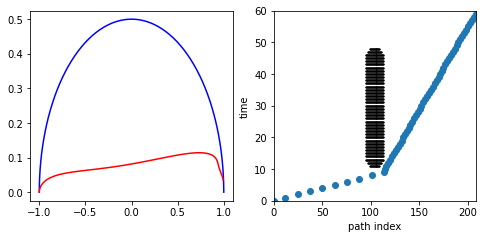

10


In [151]:
T = 3
dt = 0.05
timeSpan = np.linspace(0,T,int(T/dt))
STEPS = len(timeSpan)
m = 0.468;
#m = 1
l = 0.225;
b = 2.98e-6;
Iy = 4.856e-3;
g = 9.81;
x_dim = 12
u_dim = 4

Ut = np.zeros((STEPS-1,u_dim))*0+np.sqrt(m*g/b/4.)



# define pre-disigned path
pathInterval = 0.015
y = np.cos(np.linspace(np.pi,0,int(np.pi/pathInterval)))
z = np.sin(np.linspace(np.pi,0,int(np.pi/pathInterval)))*.5
x = y.copy()*0
r = .15
path = np.vstack([x,y,z]).T

# create moving obstacle
[tempX,tempZ] = np.meshgrid(np.linspace(-1.5,-.5,50),np.linspace(0,1,50))
wall = np.vstack((tempX.reshape((-1,)),tempX.reshape((-1,))*0,tempZ.reshape((-1,)))).T

startT = time.time()
infeasiblePtRecord = findInfeasiblePathPt(wall,path,r,timeSpan).T
print('Time used: ' + str(time.time()-startT))

# initialize alignment
# candidate = initializeAlignment(np.array([[0,90,209],[0,50,60]]), dt, pathInterval)  # priority: drone 2, wall 1
candidate = initializeAlignment(np.array([[0,115,209],[0,10,60]]), dt, pathInterval)  # priority: drone 1, wall 2



pathA = path.copy()
x_startA = np.concatenate((np.array(pathA[0,:]), np.zeros(9,)))
x_targetA = np.concatenate((np.array(pathA[-1,:]), np.zeros(9,)))
UinitA = Ut.copy()


UtA,Us_recordA,Xs_recordA,DTW_recordA,x_targetDistanceA,distance_recordA = \
    getXDTWfixTargetReverseOneStep(x_startA,UinitA,x_targetA,dt,pathA,verbose=False,finalMapping=candidate,MainMu=1e-4,InnerLoop=10,plotInterval=0)

XsA = getTrajectoryUJIT(x_startA,UtA,dt)
plotFollowingAndTable(XsA,pathA,infeasiblePtRecord,candidate)

trajA_length = len(XsA)
trajB_length = 1
pathA_length = len(pathA)
pathB_length = 1
traj_length = trajA_length
beta = int(len(pathA)/len(XsA)*3)
print(beta)

Start from: 


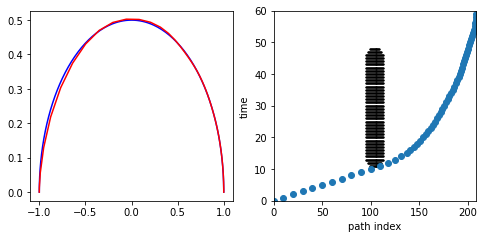

1: time: 0.13, DP time: 0.00


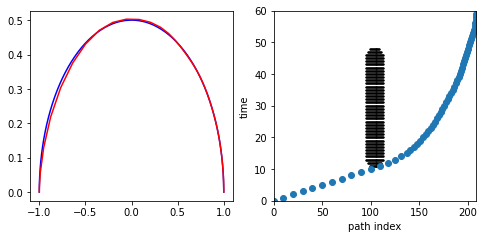

21: time: 0.12, DP time: 0.00


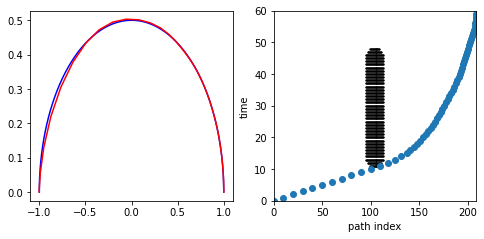

41: time: 0.13, DP time: 0.00


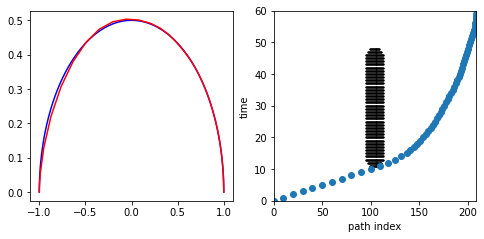

60: time: 0.13, DP time: 0.00


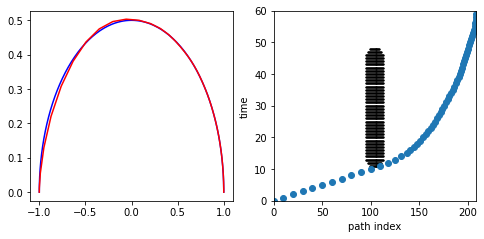

In [154]:
UsRecordA = []
XsRecordA = []
UsRecordB = []
XsRecordB = []



# candidate = np.c_[np.array(DTW_recordA[-1])[:,0],np.array(DTW_recordB[-1])[:,0]].copy()
candidateWidth = 30
TOTALPROCESS = 60
plotIntervers = 20

print('Start from: ')
plotFollowingAndTable(XsA,pathA,infeasiblePtRecord,candidate)

for idx in range(TOTALPROCESS):
    st = time.time()
    XsA = getTrajectoryUJIT(x_startA,UtA,dt)
    # XsB = getTrajectoryUJIT(x_startB,UtB,dt)
    

    LossMatrixA = np.zeros((len(XsA),len(pathA)))
    for i in range(len(XsA)):
        for j in range(len(pathA)):
            LossMatrixA[i,j] = np.linalg.norm(XsA[i,:3]-pathA[j,:3])**2

    LossMatrixB = np.zeros((1,1))
    # for i in range(len(XsB)):
    #     for j in range(len(pathB)):
    #         LossMatrixB[i,j] = np.linalg.norm(XsB[i,:3]-pathB[j,:3])**2
            
    # legalMatrix = np.zeros((len(pathA),len(pathB)))
    # for increase of obstacle
    # localThres = np.min([0.05+0.05*idx, legalThres])
    # for i in range(len(pathA)):
    #     for j in range(len(pathB)):
    #         if np.linalg.norm(pathA[i]-pathB[j]) < localThres:
    #             legalMatrix[i,j] = 1000000000.
                
    
    # determine illegal point for alignment
    legalMatrix = np.zeros_like(LossMatrixA)
    for pt in infeasiblePtRecord:
        legalMatrix[int(pt[1]),int(pt[0])] = 10000000000.

    
    # DP
    dpst = time.time()
    # pathIdxA,pathIdxB = twoAgentDPMatrixCandidate(beta,traj_length,trajA_length,trajB_length,pathA_length,pathB_length,LossMatrixA,LossMatrixB,legalMatrix,candidate,candidateWidth)
    pathIdxA = DPMatrixCandidate(beta,traj_length,trajA_length,pathA_length,LossMatrixA,legalMatrix,candidate,candidateWidth)

    dpet = time.time()
    MappingA = np.c_[pathIdxA,range(trajA_length)]
    # MappingB = np.c_[pathIdxB,range(trajB_length)]

    # SQP
    UtA,Us_recordA,Xs_recordA,DTW_recordA,x_targetDistanceA,distance_recordA = \
        getXDTWfixTargetReverseOneStep(x_startA,UtA,x_targetA,dt,pathA,verbose=False,finalMapping=MappingA,MainMu=1e-4,InnerLoop=5,plotInterval=0)
    # UtB,Us_recordB,Xs_recordB,DTW_recordB,x_targetDistanceB,distance_recordB = \
    #     getXDTWfixTargetReverseOneStep(x_startB,UtB,x_targetB,dt,pathB,verbose=False,finalMapping=MappingB,MainMu=1e-4,InnerLoop=5,plotInterval=0)
    
    # candidate = np.c_[np.array(DTW_recordA[-1])[:,0],np.array(DTW_recordB[-1])[:,0]].copy()
    candidate = np.c_[DTW_recordA[-1][:,0],range(trajA_length)].copy()
    
    UsRecordA.extend(Us_recordA)
    XsRecordA.extend(Xs_recordA)
    # UsRecordB.extend(Us_recordB)
    # XsRecordB.extend(Xs_recordB)
    
    if idx%plotIntervers == 0 or idx==TOTALPROCESS-1:
        et = time.time()
        print("%d: time: %.2f, DP time: %.2f"%(idx+1,et-st,dpet-dpst))
        plotFollowingAndTable(XsA,pathA,infeasiblePtRecord,candidate)

In [65]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

def series(idx):
    plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.plot3D(pathA[:,0],pathA[:,1],pathA[:,2],'b')
    
    wallMoved = wall.copy()
    wallMoved[:,0] = wall[:,0] + idx*2/traj_length
    ax.plot3D(wallMoved[:,0],wallMoved[:,1],wallMoved[:,2],'ok')
    # ax.plot3D(pathB[:,0],pathB[:,1],pathA[:,2],'b--')
    
    pointA = XsA[idx]
    # pointB = XsB[idx]
    # dist = np.linalg.norm(pointA-pointB)
    
    ax.plot3D([pointA[0]],[pointA[1]],[pointA[2]],'o')
    # ax.plot3D([pointB[0]],[pointB[1]],[pointB[2]],'o')
    # plt.title('distance: %.2f'%(dist))
    
    ax.set_xlim([-2, 2])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([0, 1])
#     ax.view_init(azim=0, elev=90)
    # ax.axis('equal')
    plt.show()
    return

interact(series, idx=(0,len(XsA)-1,1))

interactive(children=(IntSlider(value=29, description='idx', max=59), Output()), _dom_classes=('widget-interac…

<function __main__.series(idx)>

In [155]:
import imageio
import os

def saveFig(currentDir):
    for idx in range(traj_length):
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        ax.plot3D(pathA[:,0],pathA[:,1],pathA[:,2],'b')

        wallMoved = wall.copy()
        wallMoved[:,0] = wall[:,0] + idx*2/traj_length
        ax.plot3D(wallMoved[:,0],wallMoved[:,1],wallMoved[:,2],'ok')
        # ax.plot3D(pathB[:,0],pathB[:,1],pathA[:,2],'b--')

        pointA = XsA[idx,:3]
        # pointB = XsB[idx]
        # dist = np.linalg.norm(pointA-pointB)

        ax.plot3D([pointA[0]],[pointA[1]],[pointA[2]],'o')
        # ax.plot3D([pointB[0]],[pointB[1]],[pointB[2]],'o')
        # plt.title('distance: %.2f'%(dist))

        ax.set_xlim([-2, 2])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([0, 1])
        # ax.axis('equal')
        
        # plt.savefig(currentDir+str(idx)+'.png') 
        # plt.savefig('{}{0:02d}.png'.format(currentDir,idx))
        plt.savefig('%s%02d.png'%(currentDir,idx))
        plt.close(fig)

        

savedDir = os.getcwd() + "/fig_folder/wall_avoid/"

try:
    for filename in next(os.walk(savedDir), (None, None, []))[2]:
        os.remove(filename)
except:
    print('No need to delete')

saveFig(savedDir)

images = []
for filename in next(os.walk(savedDir), (None, None, []))[2]:
    filename = savedDir + filename
    images.append(imageio.imread(filename))
imageio.mimsave(savedDir+'movie.gif', images)

No need to delete


In [129]:
print(filenames)

['0.png', '1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6.png', '7.png', '8.png', '9.png', 'movie.gif']
